In [2]:
import os
import numpy as np
import pandas as pd
import scipy.stats as st
import numpy.random as rd
import matplotlib.pyplot as plt
from IPython.display import display
plt.style.use("ggplot")

%matplotlib inline

# Access Tracer

1. 隠れマルコフモデルの混合分布による行動モデリング
2. 複数の混合隠れマルコフモデルのオンライン忘却型学習
3. 動的モデル選択による最適混合数の決定
4. スコアリング

## データ生成

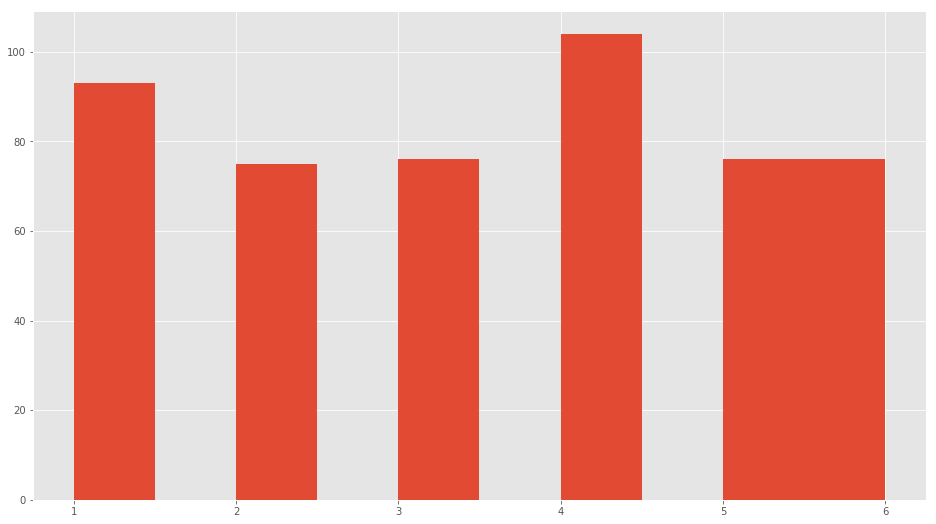

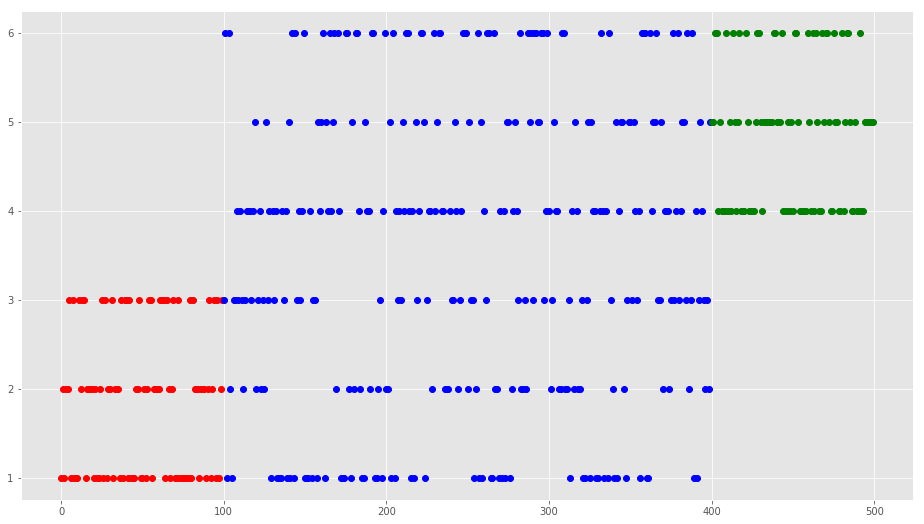

In [3]:
rd.seed(0)

dice1 = [1, 2, 3, 4, 5 ,6]
dice2 = [1, 2, 3]
dice3 = [4, 5, 6]

y1 = rd.choice(dice2, 100)
flag1 = np.array([2 for i in range(100)])
y2 = rd.choice(dice1, 300)
flag2 = np.array([1 for i in range(300)])
y3 = rd.choice(dice3, 100)
flag3 = np.array([3 for i in range(100)])

y = np.concatenate([y1, y2, y3])
flag = np.concatenate([flag1, flag2, flag3])
data = np.concatenate([y[:, np.newaxis], flag[:, np.newaxis]], axis=1)
org_data = pd.DataFrame(data)

plt.figure(figsize=(16, 9))
plt.hist(org_data[0])
plt.show()

plt.figure(figsize=(16, 9))
plt.plot(org_data.loc[org_data[1]==2][0], "o", c="r")
plt.plot(org_data.loc[org_data[1]==1][0], "o", c="b")
plt.plot(org_data.loc[org_data[1]==3][0], "o", c="g")
plt.show()

In [4]:
window_size = 5
y = np.array([np.array(org_data[0][i:i+window_size]) for i in range(org_data.shape[0]-window_size+1)])

## SDHM

In [5]:
# Given
r = 0.01 # 忘却パラメータ 0<r<1
nu = 0.1 # 推定係数
K = 3 # 混合数
n = 2 # HMMの次数
M = y.shape[0] # データ数
Tj = y.shape[1] # セッションの長さ

In [6]:
# initialize
pi = np.zeros((M, K)) # 混合係数
gamma = np.zeros((M, K, Tj)) # 初期確率
gamma_1 = np.zeros((M, K, Tj)) # 初期確率導出用
a = np.zeros((M, K, Tj)) # 遷移確率
a_1 = np.zeros((M, K, Tj)) # 遷移確率導出用
b = np.zeros((M, K, Tj)) # 出力確率
b_1 = np.zeros((M, K, Tj)) # 出力確率導出用

for i in range(K):
    pi[0][i] = 1/K
    gamma[0][i] = 1/K
    gamma_1[0][i] = 1/K
    a[0][i] = 1/K
    a_1[0][i] = 1/K
    b[0][i] = 1/K
    b_1[0][i] = 1/K

In [57]:
# calc P_k
def calc_prob_k(gamma, a, b):
    """
    gamma: 初期確率
    a: 遷移確率
    b: 出力確率
    
    HMM(隠れマルコフモデル)の確率を計算
    """
    prob = np.sum(gamma)*np.prod(a)*np.prod(b)
    return prob

# calc P
def calc_prob(gamma, a, b, pi):
    """
    gamma: 初期確率
    a: 遷移確率
    b: 出力確率
    pi: 混合係数
    
    HMMm(混合隠れマルコフモデル)の確率を計算
    """
    prob = 0
    for i in range(K):
        prob += calc_prob_k(gamma[k], a[k], b[k]) * pi[k]
    return prob

In [ ]:
# Baum-Welch(E-step)
def Baum_Welch(gamma, a, b):
    """
    gamma: 初期確率
    a: 遷移確率
    b: 出力確率
    
    alpha, beta, tau, tau_をBaum-Welchアルゴリズムで計算
    """
    alpha = np.zeros((Tj))
    beta = np.zeros((Tj))
    tau = np.zeros((Tj))
    tau_ = np.zeros((Tj))
    # forwardアルゴリズム(alphaの計算)
    alpha[0] = gamma * b[0]
    for  in (1, n):
        alpha[j] = np.sum(alpha[i-1] * a[i, j]) * b[t]
    # backwardアルゴリズム(betaの計算)
    beta[-1] = 1 
    # tau, tau_の計算
    tau = 
    tau_ = 
    
    return alpha, beta, tau, tau_

In [14]:
c = np.zeros((M, K)) # メンバーシップ確率
prob = np.zeros((M, K)) # HMMmの確率
# update
for j in range(M):
    # E-step
    for k in range(K):
        # メンバーシップ確率を更新
        c[j, k] = (1 - nu * r) * ((pi[j, k] * calc_prob_k(gamma, a, b)) / calc_prob(gamma, a, b, pi)) + (nu * r / K) 
        _, _, tau, tau_ = Baum_Welch(gamma, a, b)
    # M-step    
    for k in range(K):
        for y in Y:
            for s, s_ in zip(S, S_n1):
                pi[j+1, k] = (1 - r) * pi[j, k] + r * c[j, k]

                gamma_1[j+1, k] = (1 - r) * gamma_1[j, k] + r * c[j, k] * np.sum(tau[k, 1]) # s_n+1について
                gamma[j+1, k] = gamma_1[j+1, k] / np.sum(gamma_1[j+1, k]) # (s_1, ..., s_n)について

                a_1[j+1, k] = (1 - r) * a_1[j, k] + r * c[j, k] * np.sum(tau[k, t]) # for t in range(1, T_j-1)
                a[j+1, k] = a_1[j+1, k] / np.sum(a_1[j+1, k]) # s_n+1

                b_1[j+1, k] = (1 - r) * b_1[j, k] + r * c[j, k] * np.sum(tau_[k, t]) # for t in range(1, T_j) and y = y_tについて
                b[j+1, k] = b_1[j+1, k] / np.sum(b_1[j+1, k]) # yについて

C:\Users\kanato\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """
